# ITU-T P.1203 Model Fine-Tuning

Based on our subjective testing data

# Notes

**07.11**
So I believe the bitrate values are all wrong here
Firstly, Minh also appears to have used mbps in the p1203 calculation, which is wrong (or maybe was right at the time of the previous fine-tuning)
Now the p1203 model clearly uses kbits/second

I am collecting all video bitrates in bytes and then converting them to mbits/second, before multiplying them by 1000 to get kbits/second
I am also only storing the bitrate in kbits to avoid confusion

The way to get the megabits values is:
1. get the size of the bin file in bytes (or kilobytes)
2. convert it to megabits by dividing by 125000
3. divide it by 10 (since the bin file is for 10-seconds) to get megabits / second
4. multiply it by 1000 to get kbit/s
All of our sequences are 10-second sequences, thus we divide by 10

The video bitrates are as follows:
```
BlueSpin-r1.bin: 14000.33 kilobits
BlueSpin-r2.bin: 18358.77 kilobits
BlueSpin-r3.bin: 25381.74 kilobits
BlueSpin-r4.bin: 60218.56 kilobits
BlueSpin-r5.bin: 100957.13 kilobits
CasualSquat-r1.bin: 20028.41 kilobits
CasualSquat-r2.bin: 31350.91 kilobits
CasualSquat-r3.bin: 53280.41 kilobits
CasualSquat-r4.bin: 156102.30 kilobits
CasualSquat-r5.bin: 248934.89 kilobits
FlowerDance-r1.bin: 21305.45 kilobits
FlowerDance-r2.bin: 33934.77 kilobits
FlowerDance-r3.bin: 57028.55 kilobits
FlowerDance-r4.bin: 182492.95 kilobits
FlowerDance-r5.bin: 314833.07 kilobits
longdress-r1.bin: 45330.51 kilobits
longdress-r3.bin: 137209.71 kilobits
longdress-r5.bin: 456825.40 kilobits
loot-r1.bin: 22223.74 kilobits
loot-r3.bin: 54941.94 kilobits
loot-r5.bin: 162842.81 kilobits
ReadyForWinter-r1.bin: 15823.20 kilobits
ReadyForWinter-r2.bin: 20687.30 kilobits
ReadyForWinter-r3.bin: 28919.76 kilobits
ReadyForWinter-r4.bin: 74742.73 kilobits
ReadyForWinter-r5.bin: 132748.28 kilobits
redandblack-r1.bin: 33068.13 kilobits
redandblack-r3.bin: 73753.55 kilobits
redandblack-r5.bin: 223673.06 kilobits
soldier-r1.bin: 42745.16 kilobits
soldier-r3.bin: 113102.48 kilobits
soldier-r5.bin: 344626.97 kilobits
```

# Imports

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203 import P1203Standalone
from itu_p1203 import P1203Pq
from itu_p1203 import P1203Pa
from itu_p1203 import P1203Pv
from itertools import permutations
import json
import os
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize, Bounds, differential_evolution, basinhopping, brute, shgo, dual_annealing, direct
from enum import Enum


# Universal Data

In [33]:
# Filepaths to Mode 0 template JSON files
oldtests_mode0_json_filepath = './mode0-oldtests.json'
newtests_mode0_json_filepath = './mode0-newtests.json'
bothtests_mode0_json_filepath = './mode0-bothtests.json'

# User QoE Scores CSV File
qoe_csv_filepath = './results/test_scores.csv'

# Bitrate and resolution information for all the videos in KBPS

# New aka ComPEQ-MR Dataset
bitrates_kbps_new = {
    'BlueSpin': {'r01': 14000.33, 'r02': 18358.77, 'r03': 25381.74, 'r04': 60218.56, 'r05': 100957.13},
    'CasualSquat':  {'r01': 20028.41, 'r02': 31350.91, 'r03': 53280.41, 'r04': 156102.30, 'r05': 248934.89},
    'ReadyForWinter': { 'r01': 15823.20, 'r02': 20687.30, 'r03': 28919.76, 'r04': 74742.73, 'r05': 132748.28 },
    'FlowerDance': { 'r01': 21305.45,  'r02': 33934.77,  'r03': 57028.55, 'r04': 182492.95, 'r05': 314833.07}
}

resolution_map_new = {
    'r01': '640x360', # worse than 420p
    'r02': '852x480', # exactly 480p
    'r03': '1192x672', # bit worse than 720p
    'r04': '1533x864', # a bit better than 720p
    'r05': '1920x1080', # exactly 1080p
}

distance_map_new = {
    'd200' : '200cm'
}

# Old dataset from first round of subjective testing
bitrates_kbps_old = {
    'LongDress': { 'r1': 45330.51, 'r3': 137209.71, 'r5': 456825.40 },
    'Loot': { 'r1': 22223.74, 'r3': 54941.94, 'r5': 162842.81 },
    'RedAndBlack': { 'r1': 33068.13, 'r3': 73753.55, 'r5': 223673.06 },
    'Soldier': { 'r1': 42745.16, 'r3': 113102.48, 'r5': 344626.97 }
}

resolution_map_old = {
    'r1': '854x480', # old dataset 480p
    'r3': '1280x720', # old dataset 720p
    'r5': '1920x1080' # old dataset 1080p
}

distance_map_old = {
    'd125' : '125cm',
    'd250' : '250cm',
    'd500' : '500cm'
}

# Default P1203 coefficients
_COEFFS = {
        'u1': 72.61,
        'u2': 0.32,
        't1': 30.98,
        't2': 1.29,
        't3': 64.65,
        'q1': 4.66,
        'q2': -0.07,
        'q3': 4.06,
        'mode0': {
            'a1': 11.9983519,
            'a2': -2.99991847,
            'a3': 41.2475074001,
            'a4': 0.13183165961,
        },
        'mode1': {
            'a1': 5.00011566,
            'a2': -1.19630824,
            'a3': 41.3585049,
            'a4': 0,
            'c0': -0.91562479,
            'c1': 0,
            'c2': -3.28579526,
            'c3': 20.4098663,
        },
        'htv_1': -0.60293,
        'htv_2': 2.12382,
        'htv_3': -0.36936,
        'htv_4': 0.03409,
    }


In [34]:
# Controlling the Program

# Global Flags
old_tests = True
new_tests = True

# Set the training and the validation point cloud object names

if old_tests and new_tests:
    training_object_names = ['BlueSpin', 'CasualSquat', 'LongDress', 'Loot']
    validation_object_names = ['ReadyForWinter', 'FlowerDance', 'RedAndBlack', 'Soldier']
elif old_tests:
    training_object_names = ['LongDress', 'Loot']
    validation_object_names = ['RedAndBlack', 'Soldier']
else:
    training_object_names = ['BlueSpin', 'CasualSquat']
    validation_object_names = ['ReadyForWinter', 'FlowerDance']

# Load the Input Json
if old_tests and new_tests:
    f = open(bothtests_mode0_json_filepath)
elif old_tests:
    f = open(oldtests_mode0_json_filepath)
else:
    f = open(newtests_mode0_json_filepath)

input_json = json.load(f)

# Set the suffix for the savefile names
if old_tests and new_tests:
    graph_savename_suffix = '_BOTH'
elif old_tests:
    graph_savename_suffix = '_OLD'
else:
    graph_savename_suffix = '_NEW'

# Optimization Methods
#optimization_methods = ['basinhopping', 'brute', 'differential_evolution', 'shgo', 'dual_annealing', 'direct']
optimization_methods = ['shgo', 'dual_annealing', 'brute'] # only using these three methods for now

#current_optimization_method = None # if this is none then we go through all the ones above!
current_optimization_method = 'shgo'


#bounds = [(-5,30), (-10, 10), (-10, 160), (-10, 10)]
bounds = [(1,15), (-5, 5), (0, 80), (0, 5)]

# Training or validation
class DatasetType(Enum):
    TRAINING = 1,
    VALIDATION = 2

# groupby column names
groupby_columns = ['object', 'start_qual', 'end_qual', 'dist']


# Utility Functions

In [35]:
# Split the object string into object, start_qual, end_qual, and distance
def split_object_column(object_string):
    if 'BlueSpin' in object_string or 'FlowerDance' in object_string or 'ReadyForWinter' in object_string or 'CasualSquat' in object_string:
        split_string = object_string.split('_')
        split_string[1] = split_string[2]
        return split_string
    elif 'LongDress' in object_string or 'Loot' in object_string or 'Soldier' in object_string or 'RedAndBlack' in object_string:
        return object_string.split('_')

In [36]:
# Calculate P1203 for everything based on specified weights
def calculate_p1203_for_everything(input_json, current_coeffs=None):
    p1203_results = {
        'object': [],
        'start_qual': [],
        'end_qual': [],
        'start_bitrate': [],
        'end_bitrate': [],
        'dist' : [],
        'p1203_qoe': [],
    }

    # Calculate P1203 for old videos
    if old_tests:
        for video in list(bitrates_kbps_old.keys()):
            # Loot and LongDress had quality switches
            if video == 'Loot' or video == 'LongDress':
                bitrate_permutations = permutations(list(bitrates_kbps_old[video].values()), 2)
                quality_permutations = permutations(list(bitrates_kbps_old[video].keys()), 2)
                
                bitrates=list(bitrate_permutations)
                qualities = list(quality_permutations)

                for bitrate in list(bitrates_kbps_old[video].values()):
                    bitrates.append((bitrate, bitrate))
                
                for quality in list(bitrates_kbps_old[video].keys()):
                    qualities.append((quality, quality))

                # Loot and LongDress were always at 500cm
                distances = list([distance_map_old['d500']])
                print(distances)

            # Soldier and RedAndBlack had static qualities
            elif video == 'Soldier'or video == 'RedAndBlack':
                bitrates = list(bitrates_kbps_old[video].values())
                qualities = list(bitrates_kbps_old[video].keys())

                # Soldier and RedAndBlack were at different distances
                distances = list(distance_map_old.values())
                print(distances)

            for distance in distances:
                for bitrate, quality in zip(bitrates, qualities):
                    
                    p1203_results['object'].append(video)

                    # Loot and LongDress had quality switches
                    if video == 'Loot' or video == 'LongDress':
                        p1203_results['start_qual'].append(quality[0])
                        p1203_results['end_qual'].append(quality[1])
                        p1203_results['start_bitrate'].append(bitrate[0])
                        p1203_results['end_bitrate'].append(bitrate[1])

                        input_json['I13']['segments'][0]['bitrate'] = bitrate[0]
                        input_json['I13']['segments'][0]['resolution'] = resolution_map_old[quality[0]]
                        input_json['I13']['segments'][1]['bitrate'] = bitrate[1]
                        input_json['I13']['segments'][1]['resolution'] = resolution_map_old[quality[1]]
                    
                    # Soldier and RedAndBlack had static qualities
                    elif video == 'Soldier'or video == 'RedAndBlack':
                        p1203_results['start_qual'].append(quality)
                        p1203_results['end_qual'].append(quality)
                        p1203_results['start_bitrate'].append(bitrate)
                        p1203_results['end_bitrate'].append(bitrate)

                        input_json['I13']['segments'][0]['bitrate'] = bitrate
                        input_json['I13']['segments'][0]['resolution'] = resolution_map_old[quality]
                        input_json['I13']['segments'][1]['bitrate'] = bitrate
                        input_json['I13']['segments'][1]['resolution'] = resolution_map_old[quality]

                    # the old dataset videos are 30 fps and 10 seconds in sequence length
                    input_json['I13']['segments'][0]['fps'] = 30
                    input_json['I13']['segments'][1]['fps'] = 30
                    input_json['I13']['segments'][0]['duration'] = 5
                    input_json['I13']['segments'][1]['duration'] = 5
                    input_json['I13']['segments'][1]['start'] = 5

                    input_json['IGen']['viewingDistance'] = distance

                    print("Video: " + str(video) + 
                            ", Start bitrate: " + str(input_json['I13']['segments'][0]['bitrate']) + 
                            ", Start qual: " + str(quality) + 
                            ", End bitrate: " + str(input_json['I13']['segments'][1]['bitrate']) + 
                            ", End qual: " + str(quality) +
                            ", Distance: " + input_json['IGen']['viewingDistance'])

                    if current_coeffs is None:
                        p1203_qoe = P1203Standalone(input_json).calculate_complete()['O46']
                    else:
                        p1203_qoe = P1203Standalone(input_json, coeffs=current_coeffs).calculate_complete()['O46']

                    p1203_results['dist'].append(distance)
                    p1203_results['p1203_qoe'].append(p1203_qoe)
    
    # Calculate P1203 for new videos
    if new_tests:
        for video in list(bitrates_kbps_new.keys()):   
            bitrates = list(bitrates_kbps_new[video].values())
            qualities = list(bitrates_kbps_new[video].keys())
            distances = list([distance_map_new['d200']]) # New videos the user could move around but the starting distance was always 200cm
            print(distances)

            for distance in distances:
                for bitrate, quality in zip(bitrates, qualities):
                    p1203_results['object'].append(video)
                    p1203_results['start_qual'].append(quality)
                    p1203_results['end_qual'].append(quality)
                    p1203_results['start_bitrate'].append(bitrate)
                    p1203_results['end_bitrate'].append(bitrate)

                    input_json['I13']['segments'][0]['bitrate'] = bitrate
                    input_json['I13']['segments'][0]['resolution'] = resolution_map_new[quality]
                    input_json['I13']['segments'][1]['bitrate'] = bitrate
                    input_json['I13']['segments'][1]['resolution'] = resolution_map_new[quality]

                    # the ComPEQ-MR videos are 25 fps and 20 seconds in sequence length
                    input_json['I13']['segments'][0]['fps'] = 25
                    input_json['I13']['segments'][1]['fps'] = 25
                    input_json['I13']['segments'][0]['duration'] = 10
                    input_json['I13']['segments'][1]['duration'] = 10
                    input_json['I13']['segments'][1]['start'] = 10 # make sure to mark the start of the second segment at 10 seconds for new videos

                    input_json['IGen']['viewingDistance'] = distance

                    print("Video: " + str(video) + 
                            ", Start bitrate: " + str(input_json['I13']['segments'][0]['bitrate']) + 
                            ", Start qual: " + str(quality) + 
                            ", End bitrate: " + str(input_json['I13']['segments'][1]['bitrate']) + 
                            ", End qual: " + str(quality) +
                            ", Distance: " + input_json['IGen']['viewingDistance'])

                    if current_coeffs is None:
                        p1203_qoe = P1203Standalone(input_json).calculate_complete()['O46']
                    else:
                        p1203_qoe = P1203Standalone(input_json, coeffs=current_coeffs).calculate_complete()['O46']

                    p1203_results['dist'].append(distance)
                    p1203_results['p1203_qoe'].append(p1203_qoe)
        
    return p1203_results

In [37]:
# Calculate RMSE of Groundtruth and P1203 QoE data
def calculate_rmse(ground_truth, p1203_results):
    joined_qoe_results = p1203_results.merge(ground_truth)
    rmse_arr = []
    for idx in np.arange(joined_qoe_results.shape[0]):
        # Get all the ratings for this object and qualities by the user
        targets = joined_qoe_results.iloc[idx,:]['rate'] 

        # Get the P1203 rating for this object and quality and span it across all user ratings
        predictions = np.full(len(targets), joined_qoe_results.loc[joined_qoe_results.index[idx], 'p1203_qoe']) 

        # get the RMSE between the p1203 and the user ratings
        rmse_arr.append(np.sqrt(np.mean((predictions-targets)**2))) 
    return np.average(rmse_arr)

In [38]:
# Calculate Spearman and Pearson coefficients of QoE and Groundtruth data
def calculate_and_save_spearman_and_pearson(qoe_ground_truth, p1203_qoe, savefile_name):
    df_correlation = pd.DataFrame({'Ground truth': qoe_ground_truth, 'P.1203': p1203_qoe})
    
    # Spearman Correlation
    spear_corr = df_correlation.corr(method='spearman')
    print("Spearmann Correlation")
    print(spear_corr)

    plt.imshow(spear_corr, cmap='YlGnBu')

    plt.suptitle("Spearman Correlation " + savefile_name + graph_savename_suffix)
    
    plt.text(0, 0, spear_corr['Ground truth']['Ground truth'], ha = 'center', va = 'center', color = 'w')
    plt.text(1, 0, spear_corr['Ground truth']['P.1203'], ha = 'center', va = 'center', color = 'black')
    plt.text(0, 1, spear_corr['P.1203']['Ground truth'], ha = 'center', va = 'center', color = 'black')
    plt.text(1, 1, spear_corr['P.1203']['P.1203'], ha = 'center', va = 'center', color = 'w')

    plt.savefig("./figures/" + savefile_name + "_spearman" + graph_savename_suffix + ".pdf")
    plt.show()

    # Pearson Correlation
    pear_corr = df_correlation.corr(method='pearson')
    print("Pearson Correlation")
    print(pear_corr)

    plt.imshow(pear_corr, cmap='YlGnBu')

    plt.suptitle("Pearson Correlation " + savefile_name + graph_savename_suffix)

    plt.text(0, 0, pear_corr['Ground truth']['Ground truth'], ha = 'center', va = 'center', color = 'w')
    plt.text(1, 0, pear_corr['Ground truth']['P.1203'], ha = 'center', va = 'center', color = 'black')
    plt.text(0, 1, pear_corr['P.1203']['Ground truth'], ha = 'center', va = 'center', color = 'black')
    plt.text(1, 1, pear_corr['P.1203']['P.1203'], ha = 'center', va = 'center', color = 'w')

    plt.savefig("./figures/" + savefile_name + "_pearson" + graph_savename_suffix + ".pdf")
    plt.show()

In [39]:
# Plot a scatter graph of predicted qoe and ground truth
def make_scatter_graph(qoe_ground_truth, p1203_qoe, savefile_name, prediction_mode_label):
    plt.scatter(qoe_ground_truth, p1203_qoe)
    plt.plot([1, 5], [1, 5], color = 'red')
    plt.xlabel("Ground Truth")
    plt.ylabel(prediction_mode_label)
    
    plt.suptitle("Ground Truth vs QoE " + savefile_name + graph_savename_suffix)

    plt.savefig("./figures/" + savefile_name + graph_savename_suffix + ".pdf")
    plt.show()
    

In [40]:
# Remove outliers using the boxplot method
def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)['rate']
    q3 = frame.quantile(0.75, numeric_only=True)['rate']

    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5 * iqr)
    fence_high = q3 + (1.5 * iqr)

    # filter the frame
    filtered = (frame['rate'] >= fence_low) & (frame['rate'] <= fence_high)
    return frame.loc[filtered]


In [41]:
# Objective function to minimize
def objective_function(trial_coeffs, input_json, ground_truth_qoe_grouped_df):
    current_coeffs = _COEFFS

    current_coeffs['mode0']['a1'] = trial_coeffs[0].item()
    current_coeffs['mode0']['a2'] = trial_coeffs[1].item()
    current_coeffs['mode0']['a3'] = trial_coeffs[2].item()
    current_coeffs['mode0']['a4'] = trial_coeffs[3].item()

    p1203_qoe_dict = calculate_p1203_for_everything(input_json, trial_coeffs)
    p1203_df = pd.DataFrame.from_dict(p1203_qoe_dict)
    p1203_df = p1203_df.loc[p1203_df['object'].isin(training_object_names)]
    grouped_p1203_qoe_mean = p1203_df.groupby(groupby_columns, as_index=False).mean()

    print("Current Coeffs: " + str(current_coeffs['mode0']['a1']) + " " + str(current_coeffs['mode0']['a2']) + " " + str(current_coeffs['mode0']['a3']) + " " + str(current_coeffs['mode0']['a4']))
    
    rmse = calculate_rmse(grouped_p1203_qoe_mean, ground_truth_qoe_grouped_df)
    print("Current RMSE: " + rmse)
    
    return rmse
    

In [42]:
# Process a set of p1203 results and groundtruth dataframes
def process_p1203_and_groundtruth(p1203_df, ground_truth_df, filename_prefix, dataset_type, yaxis_label):
    if dataset_type is DatasetType.TRAINING:
        # Get the training objects from the overall p1203_df
        p1203_df_sliced = p1203_df.loc[p1203_df['object'].isin(training_object_names)]
    elif dataset_type is DatasetType.VALIDATION:
        # Get the validation objects from the overall p1203_df
        p1203_df_sliced = p1203_df.loc[p1203_df['object'].isin(validation_object_names)]

    # Group the data by object name, start quality, and end quality
    p1203_df_grouped = p1203_df_sliced.groupby(groupby_columns,as_index=False)

    # Take a mean of the qoe values that are grouped at the end
    p1203_df_grouped_mean = p1203_df_grouped.mean()

    # Make a list from the grouped values
    p1203_qoe_list = list(p1203_df_grouped_mean['p1203_qoe'])

    # Print the data
    print("--p1203_qoe_list--")
    print(p1203_qoe_list)

    if dataset_type is DatasetType.TRAINING:
        # Get only the training object data
        ground_truth_sliced = ground_truth_df.loc[ground_truth_df['object'].isin(training_object_names)]
    elif dataset_type is DatasetType.VALIDATION:
        # Get only the validation object data
        ground_truth_sliced = ground_truth_df.loc[ground_truth_df['object'].isin(validation_object_names)]

    # Group the data by object name and qualities
    ground_truth_sliced_grouped = ground_truth_sliced.groupby(groupby_columns, as_index=False)

    # Mean the grouped ratings
    ground_truth_sliced_mean = ground_truth_sliced_grouped.mean(numeric_only=True)

    # Print the data
    print("--ground_truth_sliced_mean" +" " + str(dataset_type.name) + "--")
    print(ground_truth_sliced_mean)

    # Get the qoe scores from the training data
    qoe_ground_truth_sliced = list(ground_truth_sliced_mean['rate'])

    # Print the scores
    print("--qoe_ground_truth_sliced" +" " + str(dataset_type.name) + "--")
    print(qoe_ground_truth_sliced)

    # Plot the ground truth vs the results of the original model on training data
    make_scatter_graph(qoe_ground_truth_sliced, p1203_qoe_list, filename_prefix + "_scatter_" + dataset_type.name, yaxis_label + " " + dataset_type.name)

    # Calculate and display the RMSE
    current_rmse = calculate_rmse(ground_truth_sliced_grouped.aggregate(lambda x: tuple(x)), p1203_df_grouped.aggregate(lambda x: tuple(x)))
    print(yaxis_label + " " + dataset_type.name + " RMSE: " + str(current_rmse))

    # Get Spearman and Pearson coefficients of this model and training data
    calculate_and_save_spearman_and_pearson(qoe_ground_truth_sliced, p1203_qoe_list, filename_prefix)     

# Start Computing

## Get Metrics of the Original Model

### Original Model Training Data Metrics

In [43]:
# Calculate the P1203 results for everything with the default weights
p1203_results = calculate_p1203_for_everything(input_json)

# Make a df from the p1203 results dict
p1203_df = pd.DataFrame.from_dict(p1203_results)

['500cm']
Video: LongDress, Start bitrate: 45330.51, Start qual: ('r1', 'r3'), End bitrate: 137209.71, End qual: ('r1', 'r3'), Distance: 500cm
Video: LongDress, Start bitrate: 45330.51, Start qual: ('r1', 'r5'), End bitrate: 456825.4, End qual: ('r1', 'r5'), Distance: 500cm
Video: LongDress, Start bitrate: 137209.71, Start qual: ('r3', 'r1'), End bitrate: 45330.51, End qual: ('r3', 'r1'), Distance: 500cm
Video: LongDress, Start bitrate: 137209.71, Start qual: ('r3', 'r5'), End bitrate: 456825.4, End qual: ('r3', 'r5'), Distance: 500cm
Video: LongDress, Start bitrate: 456825.4, Start qual: ('r5', 'r1'), End bitrate: 45330.51, End qual: ('r5', 'r1'), Distance: 500cm
Video: LongDress, Start bitrate: 456825.4, Start qual: ('r5', 'r3'), End bitrate: 137209.71, End qual: ('r5', 'r3'), Distance: 500cm
Video: LongDress, Start bitrate: 45330.51, Start qual: ('r1', 'r1'), End bitrate: 45330.51, End qual: ('r1', 'r1'), Distance: 500cm
Video: LongDress, Start bitrate: 137209.71, Start qual: ('r3',

In [44]:
# Continue from reading the test scores of both tests

# Read scores of both tests
ground_truth_df = pd.read_csv(qoe_csv_filepath)

# Split the columns of the ground truth data to get quality and other information
ground_truth_df[['object', 'start_qual', 'end_qual', 'dist']] = pd.DataFrame(ground_truth_df['objects'].apply(split_object_column).to_list())

# Print the data
print("--ground_truth_df--")
print(ground_truth_df)

--ground_truth_df--
                           objects  rate          object start_qual end_qual  \
0           BlueSpin_VPCC_r01_d200   1.0        BlueSpin        r01      r01   
1        FlowerDance_VPCC_r03_d200   2.0     FlowerDance        r03      r03   
2     ReadyForWinter_VPCC_r03_d200   3.0  ReadyForWinter        r03      r03   
3           BlueSpin_VPCC_r05_d200   3.0        BlueSpin        r05      r05   
4     ReadyForWinter_VPCC_r05_d200   3.0  ReadyForWinter        r05      r05   
...                            ...   ...             ...        ...      ...   
1967               Loot_r3_r3_d500   3.0            Loot         r3       r3   
1968          LongDress_r1_r5_d500   2.5       LongDress         r1       r5   
1969               Loot_r1_r5_d500   2.0            Loot         r1       r5   
1970               Loot_r3_r1_d500   2.0            Loot         r3       r1   
1971          LongDress_r5_r1_d500   3.0       LongDress         r5       r1   

      dist  
0     

--p1203_qoe_list--
[3.5852729216386914, 4.385774763876961, 4.837058584633231, 4.902406042629377, 4.895940183337771, 3.606240011756261, 4.418384824796811, 4.837058584633231, 4.895940183337771, 4.895940183337771, 4.432841021950617, 4.6717053024765605, 4.689120282009228, 4.520359468464854, 4.836957701568485, 4.8704893875445014, 4.530681518473195, 4.8545841574712405, 4.895940183337771, 4.395841983374575, 4.656138908397976, 4.673553887930643, 4.488292852995771, 4.843955852994123, 4.8704893875445014, 4.498614903004112, 4.853352961410223, 4.895940183337771]
--ground_truth_sliced_mean TRAINING--
         object start_qual end_qual  dist      rate
0      BlueSpin        r01      r01  d200  1.439024
1      BlueSpin        r02      r02  d200  2.097561
2      BlueSpin        r03      r03  d200  2.658537
3      BlueSpin        r04      r04  d200  3.268293
4      BlueSpin        r05      r05  d200  3.341463
5   CasualSquat        r01      r01  d200  1.853659
6   CasualSquat        r02      r02  d200

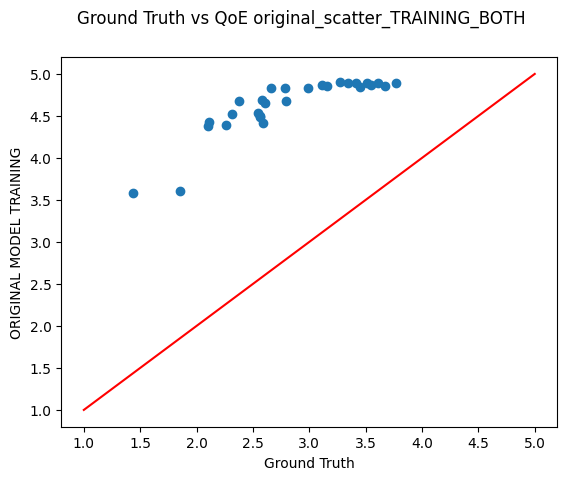

ORIGINAL MODEL TRAINING RMSE: nan
Spearmann Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.904053
P.1203            0.904053  1.000000


/home/shivi/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/shivi/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


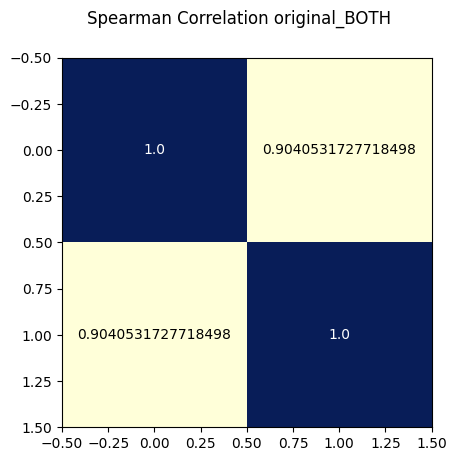

Pearson Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.847379
P.1203            0.847379  1.000000


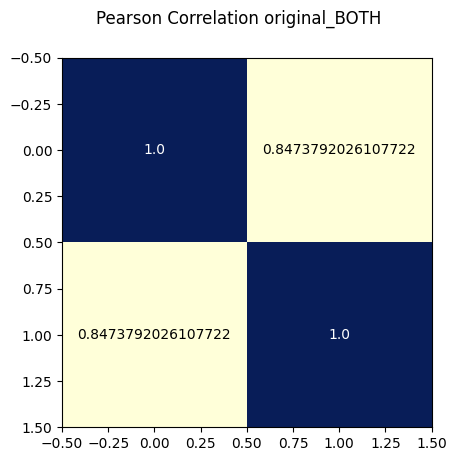

In [45]:
# Get the graphs and all the metrics for the original model on the validation dataset
process_p1203_and_groundtruth(p1203_df=p1203_df, ground_truth_df=ground_truth_df, filename_prefix="original", dataset_type=DatasetType.TRAINING, yaxis_label="ORIGINAL MODEL") 

--p1203_qoe_list--
[3.6093800843351866, 4.42174532858415, 4.837058584633231, 4.895940183337771, 4.895940183337771, 3.5929991359272795, 4.392942880641727, 4.837058584633231, 4.897756903569542, 4.895940183337771, 4.4203382277984575, 4.4203382277984575, 4.4203382277984575, 4.843955852994123, 4.843955852994123, 4.843955852994123, 4.895940183337771, 4.895940183337771, 4.895940183337771, 4.430710340003988, 4.430710340003988, 4.430710340003988, 4.836957701568485, 4.836957701568485, 4.836957701568485, 4.895940183337771, 4.895940183337771, 4.895940183337771]
--ground_truth_sliced_mean VALIDATION--
            object start_qual end_qual  dist      rate
0      FlowerDance        r01      r01  d200  1.731707
1      FlowerDance        r02      r02  d200  2.390244
2      FlowerDance        r03      r03  d200  2.902439
3      FlowerDance        r04      r04  d200  3.365854
4      FlowerDance        r05      r05  d200  3.804878
5   ReadyForWinter        r01      r01  d200  1.658537
6   ReadyForWinter 

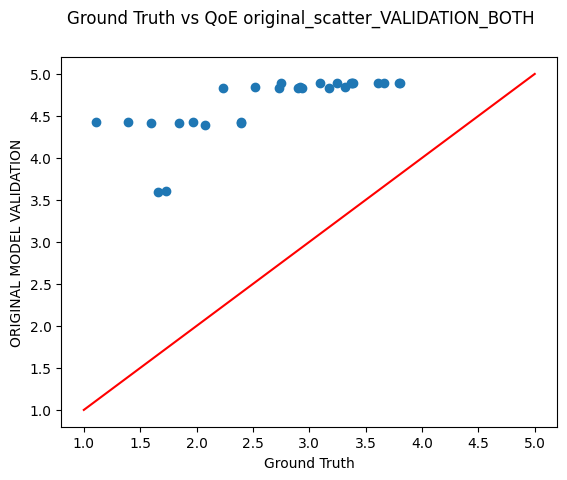

ORIGINAL MODEL VALIDATION RMSE: nan
Spearmann Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.854151
P.1203            0.854151  1.000000


/home/shivi/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/shivi/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


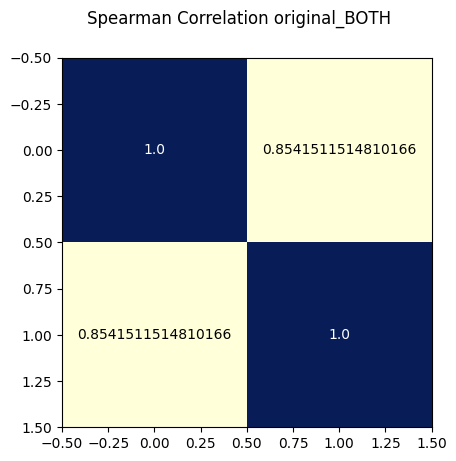

Pearson Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.741991
P.1203            0.741991  1.000000


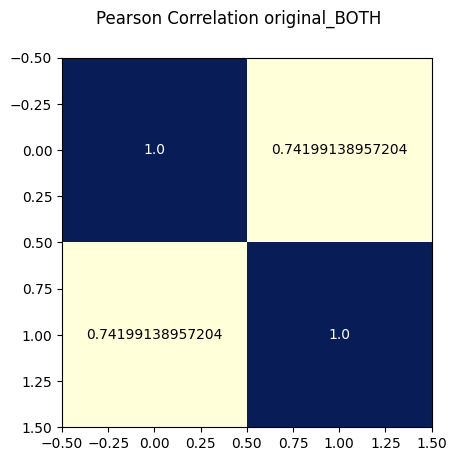

In [46]:
# Get the graphs and all the metrics for the original model on the training dataset
process_p1203_and_groundtruth(p1203_df=p1203_df, ground_truth_df=ground_truth_df, filename_prefix="original", dataset_type=DatasetType.VALIDATION, yaxis_label="ORIGINAL MODEL") 

### Original Model Validation Data Metrics

In [47]:
# Get the training objects from the overall p1203_df
p1203_df_validation = p1203_df.loc[p1203_df['object'].isin(validation_object_names)]

# Group the data by object name, start quality, and end quality
p1203_df_grouped = p1203_df_validation.groupby([groupby_columns],as_index=False)

# Take a mean of the qoe values that are grouped at the end
p1203_df_grouped_mean = p1203_df_grouped.mean()

# Make a list from the grouped values
p1203_qoe_list = list(p1203_df_grouped_mean['p1203_qoe'])

# Print the data
print("--p1203_qoe_list--")
print(p1203_qoe_list)

ValueError: Grouper and axis must be same length

## Fine-tuning the Model

In [ ]:
# ground_truth_df contains all the ground truth data from the users
# ground_truth_training_df contains the training ground truth data

# only keep the useful columns
ground_truth_df = ground_truth_df[['object', 'start_qual', 'end_qual', 'dist', 'rate']]

configurations = ground_truth_df.groupby([groupby_columns], as_index=False)

# for each configuration, filter outliers
vpcc_filtered_df = None

# for each data frame in the configurations, filter the outliers
for _, frame in configurations:
    vpcc_filtered_df = pd.concat([vpcc_filtered_df, boxplot_outlier_filter(frame)], axis=0)

# reset the index of the filtered data frame
vpcc_filtered_df = vpcc_filtered_df.reset_index(drop=True)

print("--vpcc_filtered_df--")
vpcc_filtered_df

In [ ]:
# set the ground truth training dataframe to the filtered data frame for the training objects
ground_truth_training_filtered_df = vpcc_filtered_df.loc[vpcc_filtered_df['object'].isin(training_object_names)]

print("--ground_truth_training_filtered_df--")
ground_truth_training_filtered_df

In [ ]:
# group the filtered training dataframe
ground_truth_training_grouped_df = ground_truth_training_filtered_df.groupby([groupby_columns], as_index=False).aggregate(lambda x: tuple(x))

print("--ground_truth_training_grouped_df--")
ground_truth_training_grouped_df

In [ ]:
# Actual optimization
if current_optimization_method is not None:
    print("")
else:
    print("")



In [96]:
def optimize(current_optimization_method):
    print("Optimization method: " + str(current_optimization_method))

    match current_optimization_method:
        case 'brute':
            # optimize the results using brute force
            (x0, fval, grid, Jout) = brute(objective_function, args=(input_json, ground_truth_training_grouped_df), bounds=bounds, full_output=True)
            
            # print the results
            
            print("x0: " + str(x0))
            print("fval: " + str(fval))
            print("grid: " + str(grid))
            print("Jout: " + str(Jout))

        case 'shgo':
            result = shgo(objective_function, args=(input_json, ground_truth_training_grouped_df), bounds=bounds, sampling_method='halton')

            print("Optimal Coeffs " + current_optimization_method + ": " + str(result.x))
            print("Objective function RMSE value " + current_optimization_method + ": " + str(result.fun))
            print("Objective function message " + current_optimization_method + ": " + str(result.message))

        case 'dual_annealing':
            result = dual_annealing(objective_function, args=(input_json, ground_truth_training_grouped_df), bounds=bounds)

            print("Optimal Coeffs " + current_optimization_method + ": " + str(result.x))
            print("Objective function RMSE value " + current_optimization_method + ": " + str(result.fun))
            print("Objective function message " + current_optimization_method + ": " + str(result.message))


In [ ]:
def 